## B-anthracis-pXO1-analysis
#### t-SNE Projection of Encodings for Protein Presence/Absence in pXO1 Plasmids (Section 2.4, 3.2) 

In [1]:
# === Import required libraries ===

# General
import glob
import os
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit Learn
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder

# Set directories
home_dir = "/Users/williamharrigan/Desktop/Github/B-anthracis-pXO1-analysis"

### Step 1: Load and Initialize Data


In [2]:
# === Define 3 ancestral lineages and 13 sublineages from Van Ert MN et al. 2007 ===

ancestral_lineages = {'B_lineage': ['NZ_CP076217', 'NZ_ABKG01000045', 'NZ_KN050649', 'NZ_CP076220', 'NZ_AP019732', 'NZ_CP008847', 'NZ_CP029324', 'NZ_CP076729', 'NZ_AAEN01000029', 'NZ_ABLH01000056', 'NZ_CP076188', 'NZ_CP047132', 'NZ_CP089994'],
                'C_lineage': ['NZ_CP076202'],
                'A_lineage': ['NZ_CP076223', 'NZ_AP018444', 'NZ_CP116896', 'NZ_CP116893', 'NZ_CP116890', 'NC_012579', 'NZ_CP009327', 'NZ_CP076226', 'NZ_ABJC01000062', 'NZ_QAEI01000007', 'NZ_QAEJ01000009', 'NZ_CP009597', 'NZ_CM003248', 'NZ_CP076211', 'NZ_CP009340', 'NZ_CP076196', 'NZ_CP060195', 'NZ_AAES01000048', 'NZ_KN050652', 
                              'NZ_CP139445', 'NZ_CP076199', 'NZ_CP110280', 'NZ_CP009540', 'NZ_CP081176', 'NZ_CP126464', 'NZ_CP001971', 'NZ_ABLB01000067', 'NZ_CP009980', 'NC_007322', 'NC_012656', 'NZ_CP009324', 'NZ_CP076193','NZ_CP009316', 'NZ_CP076149', 'NZ_CP076152', 'NZ_CP076179', 'NZ_CP076155', 'NZ_CP010853', 'NZ_CP076171', 'NZ_CP076165', 'NZ_CP076161', 'NZ_CP076205', 'NZ_CP076208', 'NZ_CP010814', 'NZ_CP029806', 'NZ_CP076174',
                              'NZ_CP076139', 'NZ_CP145727', 'NZ_CP096825', 'NZ_ABDN02000061', 'NZ_CP091763', 'NZ_CP076185', 'NZ_CP076142', 'NZ_CP076182', 'NZ_CP076158', 'NZ_CP010321', 'NZ_CP076214', 'NZ_ABLT01000060', 'NZ_ABKF01000059', 'NZ_AAER01000043']}
sublineages = {
    'kruger': ['NZ_CP076217', 'NZ_ABKG01000045', 'NZ_KN050649', 'NZ_CP076220'],
    'cneva': ['NZ_AP019732', 'NZ_CP008847', 'NZ_CP029324', 'NZ_CP076729', 'NZ_AAEN01000029', 'NZ_ABLH01000056', 'NZ_CP076188', 'NZ_CP047132', 'NZ_CP089994'],
    'c_group': ['NZ_CP076202'],
    'ancient_a': ['NZ_CP076223', 'NZ_AP018444', 'NZ_CP116896', 'NZ_CP116893', 'NZ_CP116890'],
    'vollum': ['NC_012579', 'NZ_CP009327', 'NZ_CP076226', 'NZ_ABJC01000062'],
    'v770': ['NZ_QAEI01000007', 'NZ_QAEJ01000009', 'NZ_CP009597', 'NZ_CM003248', 'NZ_CP076211'],
    'aust_94': ['NZ_CP009340', 'NZ_CP076196', 'NZ_CP060195', 'NZ_AAES01000048', 'NZ_KN050652'],
    'sterne': ['NZ_CP139445', 'NZ_CP076199', 'NZ_CP110280', 'NZ_CP009540'],
    'ames': ['NZ_CP081176', 'NZ_CP126464', 'NZ_CP001971', 'NZ_ABLB01000067', 'NZ_CP009980', 'NC_007322', 'NC_012656'],
    'br_008_011': [
        'NZ_CP009324', 'NZ_CP076193',
        'NZ_CP009316', 'NZ_CP076149',
        'NZ_CP076152', 'NZ_CP076179', 'NZ_CP076155', 'NZ_CP010853', 'NZ_CP076171', 'NZ_CP076165',
        'NZ_CP076161', 'NZ_CP076205', 'NZ_CP076208', 'NZ_CP010814', 'NZ_CP029806', 'NZ_CP076174',
        'NZ_CP076139'
    ],
    'tsiankovskii' : ['NZ_CP145727', 'NZ_CP096825', 'NZ_ABDN02000061', 'NZ_CP091763'],
    'germany' : ['NZ_CP076185', 'NZ_CP076142', 'NZ_CP076182', 'NZ_CP076158'],
    'wna': ['NZ_CP010321', 'NZ_CP076214', 'NZ_ABLT01000060', 'NZ_ABKF01000059', 'NZ_AAER01000043']
}



In [3]:
# === Load plasmid protein composition from NCBI Genome database annotations ===

plasmids = {}
annotation_files = glob.glob(f"{home_dir}/files/NCBI_genome_annotations/*")

for file_path in annotation_files:
    file_name = os.path.basename(file_path)
    plasmid_id = "_".join(file_name.split("_")[-3:-1])
    
    with open(file_path, "r") as f:
        proteins = [
            line.split("\t")[0]
            for line in f
            if not line.startswith("RefSeq/Protein ID")
        ]
    
    plasmids[plasmid_id] = proteins

# === Build sequence_df: maps each genome to its proteins ===

plasmid_df = pd.DataFrame(
    [
        (genome_id, protein)
        for genome_id, proteins in plasmids.items()
        for protein in proteins if protein
    ],
    columns=["plasmid_id", "protein_sequence_id"]
)

# === One-hot encode protein presence across genomes ===

plasmid_sequences_df = (
    plasmid_df
    .groupby(["plasmid_id", "protein_sequence_id"])["protein_sequence_id"]
    .count()
    .unstack(fill_value=0)
)

plasmid_sequences_encode = plasmid_sequences_df.map(lambda x: 1 if x != 0 else 0)

# === Preview ===
plasmid_df.head()
plasmid_sequences_encode.iloc[:5, :5]


protein_sequence_id,WP_000019180.1,WP_000019181.1,WP_000022108.1,WP_000022644.1,WP_000026994.1
plasmid_id,,,,,
NC_007322,0,0,1,1,0
NC_012579,0,0,1,1,0
NC_012656,0,0,1,1,0
NZ_AAEN01000029,0,1,1,1,1
NZ_AAER01000043,0,0,1,1,0


### Step 2: Define function to plot t-SNE projection of plasmid protein composition vectors


In [4]:
def plot_plasmid_tsne(plasmid_vectors, plasmid_ids, sublineages, color_dict, perplexity=10, random_state=42):
    """
    Plots a t-SNE visualization of plasmid vectors colored by sublineage.

    Parameters:
        plasmid_vectors (np.ndarray): One-hot or embedded plasmid feature matrix (n_samples x n_features)
        plasmid_ids (list or Index): List of plasmid IDs corresponding to rows in plasmid_vectors
        sublineages (dict): Mapping of sublineage name to list of genome IDs
        color_dict (dict): Mapping of sublineage name to color
        perplexity (int): Perplexity parameter for t-SNE
        random_state (int): Random seed for reproducibility
    """
    # === Perform t-SNE on plasmid vectors ===
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity)
    tsne_coords = tsne.fit_transform(plasmid_vectors)

    # === Map each plasmid ID to its lineage group ===
    labels = []
    for plasmid_id in plasmid_ids:
        assigned = False
        for strain, genome_list in sublineages.items():
            if any(genome in plasmid_id for genome in genome_list):
                labels.append(strain)
                assigned = True
                break
        if not assigned:
            labels.append("Unclassified")

    # === Assign colors to lineage/sublineages ===
    labels = np.array(labels)
    unique_strains = sorted(set(labels))

    # === Plot t-SNE ===
    plt.figure(figsize=(12, 8))

    for strain in unique_strains:
        mask = labels == strain
        plt.scatter(
            tsne_coords[mask, 0],
            tsne_coords[mask, 1],
            label=strain,
            color=color_dict.get(strain, "grey"),
            s=100
        )

    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    return tsne_coords, labels

### Step 3: Plot t-SNE projections according to plasmid lineage and sublineages

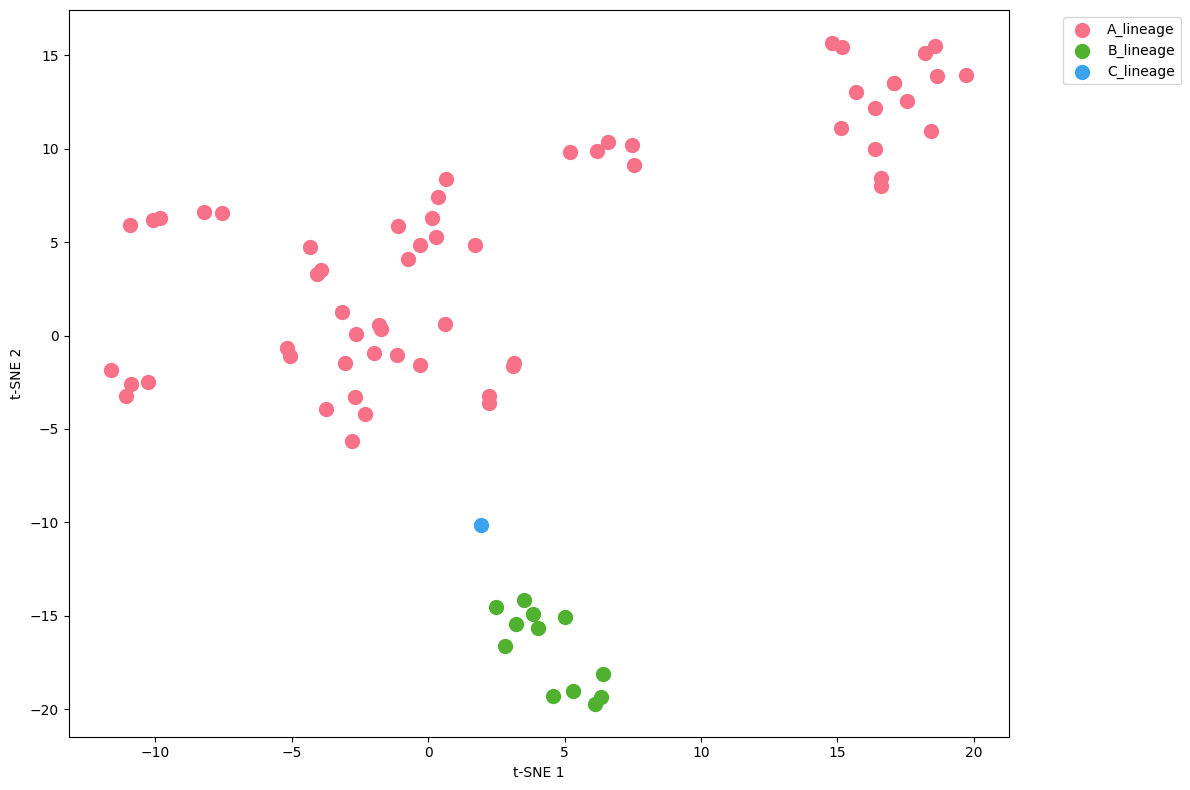

In [5]:
# === Convert plasmid one-hot encoded matrix to vectors ===
plasmid_vectors = plasmid_sequences_encode.values
plasmid_ids = plasmid_sequences_encode.index

# === Generate a color dictionary based on ancestral lineages === 
all_strains = sorted(ancestral_lineages.keys())
color_palette = sns.color_palette("husl", len(all_strains))
color_dict = dict(zip(all_strains, color_palette))

# === Call t-SNE plotting function ===
ancestral_tsne_coords, ancestral_labels = plot_plasmid_tsne(plasmid_vectors, plasmid_ids, ancestral_lineages, color_dict)

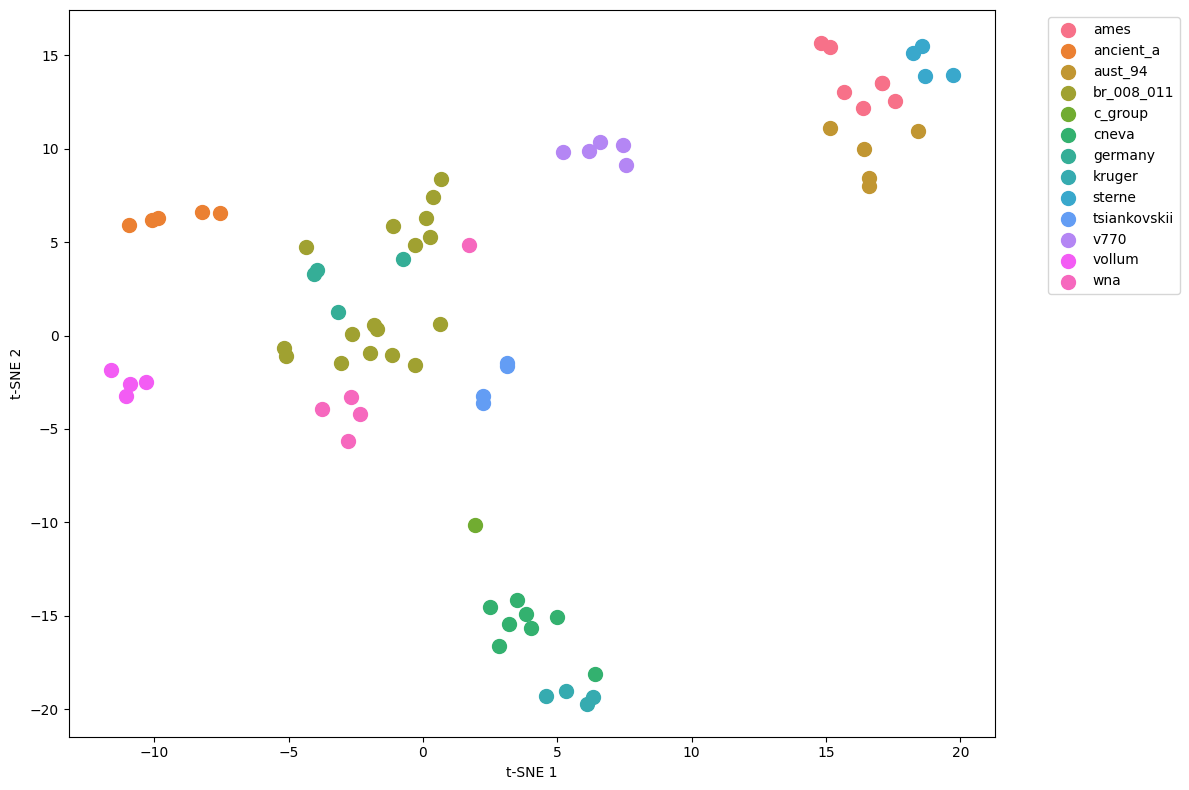

In [6]:
# === Convert plasmid one-hot encoded matrix to vectors ===
plasmid_vectors = plasmid_sequences_encode.values
plasmid_ids = plasmid_sequences_encode.index

# === Generate a color dictionary based on sublineages === 
all_strains = sorted(sublineages.keys())
color_palette = sns.color_palette("husl", len(all_strains))
color_dict = dict(zip(all_strains, color_palette))

# === Call t-SNE plotting function ===
sublineage_tsne_coords, sublineage_labels = plot_plasmid_tsne(plasmid_vectors, plasmid_ids, sublineages, color_dict)


### Step 4: Compute Silhouette scores for t-SNE clusters


In [7]:
def compute_silhouette_by_strain(tsne_coords, strain_labels):
    """
    Computes and returns mean silhouette scores per strain group.

    Parameters:
        tsne_coords (np.ndarray): 2D t-SNE coordinates (n_samples x 2)
        strain_labels (list or array-like): Strain/group labels corresponding to each sample

    Returns:
        pd.Series: Mean silhouette score per strain
    """
    # === Encode labels numerically ===
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(strain_labels)
    
    # === Compute silhouette scores per sample ===
    sample_silhouette_values = silhouette_samples(tsne_coords, encoded_labels)
    
    # === Create DataFrame with strain names and silhouette scores ===
    strain_names = label_encoder.inverse_transform(encoded_labels)
    silhouette_df = pd.DataFrame({
        'strain': strain_names,
        'silhouette_score': sample_silhouette_values
    })
    
    # === Compute mean silhouette score per strain ===
    mean_silhouette_per_strain = silhouette_df.groupby('strain')['silhouette_score'].mean()
    
    return mean_silhouette_per_strain


In [8]:
# === Compute silhouette scores from labels and coordinates of t-SNE projections ===

# Ancestral lineage silhouette scores
ancestral_lineage_mean_scores = compute_silhouette_by_strain(ancestral_tsne_coords, ancestral_labels)
print("Mean Silhouette Score per ancestral lineage:")
print(ancestral_lineage_mean_scores)
print()

# Sublineage silhouette scores
sublineage_mean_scores = compute_silhouette_by_strain(sublineage_tsne_coords, sublineage_labels)
print("Mean Silhouette Score per sublineage:")
print(sublineage_mean_scores)
print()


Mean Silhouette Score per ancestral lineage:
strain
A_lineage    0.143540
B_lineage    0.522654
C_lineage    0.000000
Name: silhouette_score, dtype: float32

Mean Silhouette Score per sublineage:
strain
ames            0.282455
ancient_a       0.751495
aust_94         0.387757
br_008_011     -0.192089
c_group         0.000000
cneva           0.406999
germany         0.391348
kruger          0.741610
sterne          0.563005
tsiankovskii    0.761816
v770            0.855793
vollum          0.883446
wna             0.194857
Name: silhouette_score, dtype: float32



### References

Van Ert, M. N., Easterday, W. R., Huynh, L. Y., Okinaka, R. T., Hugh-Jones, M. E., et al. (2007).  
*Global Genetic Population Structure of Bacillus anthracis.* PLOS ONE, 2(5), e461. https://doi.org/10.1371/journal.pone.0000461
